## kWTA_ei
This program explores the implementation of a kWTA network using a E-I network.

It also sets the infrastructure for:
* Visualization of network activity
* automatic documentation of simulation sessions
* saving network and session states
* parallel parameter search (currently in kWTA_ei_mp)

Sergio Verduzco,               
October-November 2017

In [1]:
%cd ..
from draculab import *
from matplotlib import pyplot as plt
import time
from matplotlib.animation import FuncAnimation
import dill

/home/z/projects/draculab


In [2]:
%%capture capt 
# logging draculab version used for this session
print('======================================================')
print('| kWTA_ei is currently using this draculab commit: |')
print('======================================================')
!git log -1 --oneline --color=never

In [3]:
# Write the output of the cell above in the simulation log
with open('/home/z/projects/draculab/logs/kWTA_ei_simlog.txt', 'a') as f:
    f.write(capt.stdout)
    f.close()

In [2]:
class ei_net():
    def __init__(self):
        # The history list will store strings containing the instructions doing parameter changes, 
        # building the network, or running a simulation.
        self.history = ["__init__ at " + time.ctime()]
        """ All the default parameter dictionaries are below. 
            Time units are seconds for compatibility with the pendulum model.
            Length units for geometry dictionaries are centimeters.
            Axonal conduction speed is ~1 m/s, synaptic delay about 1 ms, but 5 ms for the population response.
        """
        # parameter dictionary for the network
        self.net_params = {'min_delay' : 0.005, # notice delays below are set using this value
                           'min_buff_size' : 10,
                           'rtol' : 1e-5,
                           'atol' : 1e-5 } 
        # parameter dictionary for the excitatory units
        self.unit_pars = {'init_val' : 0.5, 
                          'slope' : 2.,
                          'thresh' : 1.,
                          'tau' : 0.02,  # 20 ms time constant
                          'tau_fast' : 0.04, # 40 ms for fast low-pass filter
                          'tau_slow' : .5, # 500 ms for slow low-pass filter
                          'type' : unit_types.sigmoidal }
        # geometry dictionary for excitatory population
        self.exc_geom = {'shape':'sheet', 
                     'extent':[1.,1.], # 1 square centimeter grid
                     'center':[0.,0.], 
                     'arrangement':'grid', 
                     'rows':20, 
                     'columns':20,  # 400 units
                     'jitter' : 0.02 }
        # geometry dictionary for inhibitory population (keep extent and center same as above)
        self.inh_geom = {'shape':'sheet', 
                     'extent':[1.,1.], 
                     'center':[0.,0.], 
                     'arrangement':'grid', 
                     'rows':10, 
                     'columns':10,  # 100 units
                     'jitter' : 0.02 }
        # parameters for the inhibitory units
        self.inh_pars = {'init_val' : 0.5, 
                         'slope' : 4.,
                         'thresh' : .5,
                         'tau' : 0.04, # 40 ms time constant
                         'tau_fast' : 0.04,
                         'tau_slow' : .5,
                         'type' : unit_types.sigmoidal } 
        # parameters for the input units
        self.n_units = {'inp' : 5} # number of input units
        self.inp_pars = {'type' : unit_types.source,
                         'init_val' : 0.,
                         'tau_fast' : 0.04,
                         'coordinates' : np.array([0.,0.]), # for plotting purposes
                         'function' : lambda x: None }
        # E-E connections
        self.e2e_conn = {'connection_type' : 'convergent',
            'mask' : {'circular': {'radius': 0.1}},
            'kernel' : 1., #{'gaussian' : {'p_center' : 1.1, 'sigma' : 0.3} },
            'delays' : {'linear' : {'c' : self.net_params['min_delay'], 'a' : 10.}},
            'weights' : {'linear' : {'c' : 0.3, 'a' : 0.1}},
            #'number_of_connections' : 6,
            'allow_autapses' : True,
            'allow_multapses' : False,
            'edge_wrap' : True,
            'boundary' : {'center': np.array(self.exc_geom['center']), 'extent' : self.exc_geom['extent']} }
        self.e2e_syn = {'type' : synapse_types.static,
                        'lrate' : 0.05 }
        # E-I connections
        self.e2i_conn = {'connection_type' : 'convergent',
            'mask' : {'annular': {'inner_radius': 0.1, 'outer_radius': 0.4}},
            'kernel' : {'linear': {'c': 1.1, 'a': 2.5}},
            'delays' : {'linear' : {'c' : self.net_params['min_delay'], 'a' : 10.}},
            'weights' : {'linear' : {'c' : 0.1, 'a' : 0.02}},
            #'number_of_connections' : 14,
            'edge_wrap' : True,
            'boundary' : {'center': np.array(self.inh_geom['center']), 'extent' : self.inh_geom['extent']} }
        self.e2i_syn = {'type' : synapse_types.static,
                        'lrate' : 0.05 }
        # I-E connections
        self.i2e_conn = {'connection_type' : 'convergent',
            'mask' :  {'circular': {'radius': 0.2}},
            'kernel' : 1,
            'delays' : {'linear' : {'c' : self.net_params['min_delay'], 'a' : 10.}},
            'weights' : {'linear' : {'c' : -.1, 'a' : 0.001}},
            'edge_wrap' : True,
            'boundary' : {'center': np.array(self.exc_geom['center']), 'extent' : self.exc_geom['extent']} }
        self.i2e_syn = {'type' : synapse_types.homeo_inh,
            'lrate' : 0.1,
            'des_act' : 0.3 }
        # I-I connections
        self.i2i_conn = {'connection_type' : 'convergent',
            'mask' : {'circular': {'radius': 0.3}},
            'kernel' : 0.5,
            'delays' : {'linear' : {'c' : self.net_params['min_delay'], 'a' : 10.}},
            'weights' : {'linear' : {'c' : -.1, 'a' : 0.001}},
            'edge_wrap' : True,
            'boundary' : {'center': np.array(self.inh_geom['center']), 'extent' : self.inh_geom['extent']} }
        self.i2i_syn = {'type' : synapse_types.homeo_inh,
            'lrate' : 0.1,
            'des_act' : 0.3 }
        # inputs to E and I
        self.i2u_conn_spec = {'rule' : 'all_to_all',
                 'delay' : self.net_params['min_delay'] }
        self.i2u_syn_spec = {'type' : synapse_types.bcm,
                'lrate' : 0.05,
                'init_w' : {'distribution' : 'equal_norm', 'norm' : 1.} }
        self.notes = '' # comments after visualizing simulation results
        # fixing random seed
        seed = 19680801
        np.random.seed(seed)
        # I also use the 'random' module, so I should also run random.seed(seed).
        self.history.append('np.random.seed = ' + str(seed))
           
    def build(self):
        """ Create the draculab network. """
        # store record of network being built
        self.history.append('build()')
        # Set derived parameters
        self.e2e_conn['delays'] = {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}}
        self.e2i_conn['delays'] = {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}}
        self.i2e_conn['delays'] = {'linear' : {'c' : self.net_params['min_delay'], 'a' : 0.1}}
        self.i2u_conn_spec['delay'] = self.net_params['min_delay']
        self.e2e_conn['boundary'] = {'center': np.array(self.exc_geom['center']), 'extent' : self.exc_geom['extent']}
        self.e2i_conn['boundary'] = {'center': np.array(self.inh_geom['center']), 'extent' : self.inh_geom['extent']}
        self.i2e_conn['boundary'] = {'center': np.array(self.exc_geom['center']), 'extent' : self.exc_geom['extent']}
        # Create an auxiliary topology object
        topo = topology()
        # Create network
        self.net = network(self.net_params)
        # Create excitatory population
        self.units = topo.create_group(self.net, self.exc_geom, self.unit_pars)
        # Create group of inhibitory units
        self.inh = topo.create_group(self.net, self.inh_geom, self.inh_pars)
        # Create input units
        self.inp = self.net.create(self.n_units['inp'], self.inp_pars)
        # E-E connections
        topo.topo_connect(self.net, self.units, self.units, self.e2e_conn, self.e2e_syn)
        # E-I connections
        topo.topo_connect(self.net, self.units, self.inh, self.e2i_conn, self.e2i_syn)
        # I-E connections
        topo.topo_connect(self.net, self.inh, self.units, self.i2e_conn, self.i2e_syn)
        # I-I connections
        topo.topo_connect(self.net, self.inh, self.inh, self.i2i_conn, self.i2i_syn)
        # Connect the inputs to the units
        self.net.connect(self.inp, self.units, self.i2u_conn_spec, self.i2u_syn_spec)
        self.net.connect(self.inp, self.inh, self.i2u_conn_spec, self.i2u_syn_spec)
        
    def set_param(self, dictionary, entry, value):
        """ Change a value in a parameter dictionary. 
        
            dictionary: a string with the name of one of the parameter dictionaries in __init__
            entry: a string with the name of the entry we'll modify
            value: the value we'll assign (can be any appropriate Python object) 
        """
        if 'build()' in self.history:
            raise AssertionError('Setting a parameter value after network has been built')     
        self.__getattribute__(dictionary)[entry] = value  # set the new value
        self.history.append(dictionary + '[\'' + entry + '\'] = ' + str(value) ) # record assignment
            
    def make_sin_pulse(self, t_init, t_end, per, amp): 
        """ This function returns a function implementing a localized sinusoidal bump(s). """
        return lambda t : amp * ( np.sqrt( 0.5 * (1. + 
                      np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) ) ) ) #if (t_init < t and t < t_end) else 0.

    def input_vector(self):
        """This function returns an input vector. Different distributions can be implemented with this. """
        # right now it's just random vectors with unit norm
        vec = np.random.uniform(0., 1., self.n_units['inp'])
        return  vec / np.linalg.norm(vec)
        
    def run(self, n_pres, pres_time, alpha=0.3):
        """ Run a simulation, presenting n_pres patterns, each lasting pres_time. 
            
            The argument alpha determines how fast the input amplitudes drift.
            
            Updates:
                self.all_times: 1-D numpy array with the times for each data point in all_activs.
                self.all_activs: 2-D numpy array with the activity of all units at each point in all_times. 
        """
        # store a record of this simulation
        self.history.append('run(' + str(n_pres) + ',' + str(pres_time) + ',' + str(alpha) + ')') 
        # initialize storage of results
        self.all_times = []
        self.all_activs = []
        start_time = time.time()
        inp_vel = np.zeros(self.n_units['inp']) # initial velocity for the input drift
        inp_vec = self.input_vector() # initial amplitudes of the inputs
        # present input patterns
        for pres in range(n_pres):
            print('Simulating presentation ' + str(pres), end='\r')
            pres_start = time.time()
            t = self.net.sim_time
            inp_accel = self.input_vector() # having an acceleration confers "momentum" to the input drift
            inp_vel = (1.-alpha)*inp_vel + alpha*inp_accel 
            inp_vec = (1.-alpha)*inp_vec + alpha*inp_vel
            for i in self.inp:
                self.net.units[i].set_function(self.make_sin_pulse(t, t+pres_time, pres_time, inp_vec[i-self.inp[0]]))
        
            times, activs, plants = self.net.run(pres_time)
            self.all_times.append(times)
            self.all_activs.append(activs)
            print('Presentation %s lasted %s seconds.' % (pres, time.time() - pres_start), end='\n')

        self.all_times = np.concatenate(self.all_times)
        self.all_activs = np.concatenate(self.all_activs, axis=1)
        print('Execution time is %s seconds' % (time.time() - start_time)) 
        return self # see rant on multiprocessing
        
    def basic_plot(self):
        #%matplotlib inline
        inp_fig = plt.figure(figsize=(10,5))
        inputs = np.transpose([self.all_activs[i] for i in self.inp])
        plt.plot(self.all_times, inputs, linewidth=1, figure=inp_fig)
        plt.title('Inputs')

        unit_fig = plt.figure(figsize=(10,5))
        some_acts = np.transpose(self.all_activs[[self.units[i] for i in [0,1,-1,-2]]])
        plt.plot(self.all_times, some_acts, figure=unit_fig)
        plt.title('Some unit activities')

        inh_fig = plt.figure(figsize=(10,5))
        some_inh = np.transpose(self.all_activs[[self.inh[i] for i in [0,1,-1,-2]]])
        plt.plot(self.all_times, some_inh, figure=inh_fig)
        plt.title('some inhibitory units')

        plt.show()
        
    def activ_anim(self, thr, slider=False):
        """ An animation to visualize the activity of the excitatory units. 
        
            Units whose activity surpasses 'thr' will be highlighted.
            It is assumed that this import statement has happened:
            from matplotlib.animation import FuncAnimation
        """
        %matplotlib qt5
        # notebook or qt5 

        self.unit_fig = plt.figure(figsize=(10,10))
        self.ax = self.unit_fig.add_axes([0, 0, 1, 1], frameon=False)
        self.ax.set_xlim(-1, 1), self.ax.set_xticks([])
        self.ax.set_ylim(-1, 1), self.ax.set_yticks([])
        xcoords = [ u.coordinates[0] for u in [self.net.units[i] for i in self.units] ]
        ycoords = [ u.coordinates[1] for u in [self.net.units[i] for i in self.units] ]
        self.scat = self.ax.scatter(xcoords, ycoords, s=20.*self.all_activs[self.units,0])
        self.n_data = len(self.all_activs[0])
        self.act_thr = thr
        
        if not slider:
            animation = FuncAnimation(self.unit_fig, self.update_act_anim, 
                                  interval=100, save_count=int(round(self.net.sim_time/self.net.min_delay)))    
            return animation
        else:
            from ipywidgets import interact
            widget = interact(self.update_act_anim, frame=(1,self.n_data))
            return widget
        
    def color_fun(self, activ):
        # given the units activity, maps into a color. activ may be an array.
        activ =  np.maximum(0.1,  activ*np.maximum(np.sign(activ - 0.8), 0.))
        return np.outer(activ, np.array([0., .5, 1., .5]))

    def update_act_anim(self, frame):
        # Each frame advances one simulation step (min_delay time units)
        idx = frame%self.n_data
        cur_time = self.net.min_delay*idx
        self.scat.set_sizes(300.*self.all_activs[self.units,idx])
        self.scat.set_color(self.color_fun(self.all_activs[self.units,idx]))
        self.unit_fig.suptitle('Time: ' + '{:f}'.format(cur_time))
        return self.ax,

    def conn_anim(self, source, sink, interv=100, slider=False, weights=False):
        """ An animation to visualize the connectivity of populations. 
    
            source and sink are lists with the IDs of the units whose connections we'll
            visualize. Each frame of the animation shows: for a particular unit in source,
            all the neurons in sink that receive connections from it (left plot), and for 
            a particular unit in sink, all the units in source that send it connections
            (right plot).
        
            interv is the refresh interval (in ms) used by FuncAnimation.
            
            If weights=True, then the dots size and color will reflect the connection weight.
        
            It is assumed that this import statement has happened:
            from matplotlib.animation import FuncAnimation
        """
        %matplotlib qt5
        # notebook or qt5 
        
        # update_conn_anim uses these values
        self.len_source = len(source)
        self.len_sink = len(sink)
        self.source_0 = source[0]
        self.sink_0 = sink[0]

        # flattening net.syns, leaving only the source-sink connections 
        self.all_syns = []
        for syn_list in [self.net.syns[i] for i in sink]:
            syn_list = [s for s in syn_list if s.preID in source]
            self.all_syns += syn_list
    
        # getting lists with the coordinates of all source, sink units
        source_coords = [u.coordinates for u in [self.net.units[i] for i in source]]
        sink_coords = [u.coordinates for u in [self.net.units[i] for i in sink]]
        source_x = [c[0] for c in source_coords]
        source_y = [c[1] for c in source_coords]
        sink_x = [c[0] for c in sink_coords]
        sink_y = [c[1] for c in sink_coords]

        # setting colors
        self.std_src = [0., 0.5, 0., 0.5]
        self.std_snk = [0.5, 0., 0., 0.5]
        self.big_src = [0., 0., 1., 1.]
        self.big_snk = [0., 0., 1., 1.]

        # constructing figure, axes, path collections
        self.conn_fig = plt.figure(figsize=(12,7))
        self.ax1 = self.conn_fig.add_axes([0.0, 0.01, .49, 0.95], frameon=True, aspect=1)
        self.ax2 = self.conn_fig.add_axes([0.51, 0.01, .49, 0.95], frameon=True, aspect=1)
        self.src_col1 = self.ax1.scatter(source_x, source_y, s=2, c=self.std_src)
        self.snk_col1 = self.ax1.scatter(sink_x, sink_y, s=2, c=self.std_snk)
        self.src_col2 = self.ax2.scatter(source_x, source_y, s=2, c=self.std_src)
        self.snk_col2 = self.ax2.scatter(sink_x, sink_y, s=2, c=self.std_snk)
        self.ax1.set_title('sent connections')
        self.ax2.set_title('received connections')
        self.ax2.set_yticks([])
        
        if weights:
            update_fun = self.update_weight_anim
            # extract the weight matrix
            self.w_mat = np.zeros((len(sink), len(source)))
            for syn in self.all_syns:
                self.w_mat[syn.postID - sink[0], syn.preID - source[0]] = abs(syn.w)
                self.w_mat /= np.amax(self.w_mat) # normalizing (maximum is 1)
                self.cmap = plt.get_cmap('Reds') # getting colormap
        else:
            update_fun = self.update_conn_anim
            
        if not slider:
            animation = FuncAnimation(self.conn_fig, update_fun, interval=interv, blit=True)
            return animation
        else:
            from ipywidgets import interact
            widget = interact(update_fun, frame=(1, max(self.len_source, self.len_sink)))
            return widget
    
    def update_conn_anim(self, frame): 
        sou_u = frame%self.len_source # source unit whose receivers we'll visualize
        snk_u = frame%self.len_sink # sink unit whose senders we'll visualize
    
        # PLOTTING THE RECEIVERS OF sou_u ON THE LEFT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = np.tile(self.std_src,(self.len_source,1))
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        source_sizes[sou_u] = 30
        source_colors[sou_u] = self.big_src
        # getting targets of projections from the unit 'sou_u'
        targets = [syn.postID - self.sink_0 for syn in self.all_syns if syn.preID == sou_u + self.source_0]
        # setting the colors and sizes
        sink_colors[targets] = self.big_snk
        sink_sizes[targets] = 15
        self.src_col1.set_sizes(source_sizes)
        #ax1.get_children()[0].set_sizes(source_sizes)   # sizes for the source units
        self.snk_col1.set_sizes(sink_sizes)   
        self.src_col1.set_color(source_colors)
        self.snk_col1.set_color(sink_colors)
        
        # PLOTTING THE SENDERS TO snk_u ON THE RIGHT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = np.tile(self.std_src, (self.len_source,1))
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        sink_sizes[snk_u] = 30
        sink_colors[snk_u] = self.big_snk
        # getting senders of projections to the unit 'snk_u'
        senders = [syn.preID - self.source_0 for syn in self.all_syns if syn.postID == snk_u + self.sink_0]
        # setting the colors and sizes
        source_colors[senders] = self.big_src
        source_sizes[senders] = 15
        self.src_col2.set_sizes(source_sizes)
        self.snk_col2.set_sizes(sink_sizes)   
        self.src_col2.set_color(source_colors)
        self.snk_col2.set_color(sink_colors)
    
        return self.ax1, self.ax2,
    
    def update_weight_anim(self, frame): 
        sou_u = frame%self.len_source # source unit whose receivers we'll visualize
        snk_u = frame%self.len_sink # sink unit whose senders we'll visualize
            
        # PLOTTING THE RECEIVERS OF sou_u ON THE LEFT AXIS
        source_sizes = np.tile(2, self.len_source)
        sink_sizes =  2. + 400.*self.w_mat[:,sou_u]
        source_colors = np.tile(self.std_src,(self.len_source,1))
        sink_colors =  self.cmap.__call__(self.w_mat[:,sou_u])
        source_sizes[sou_u] = 30
        source_colors[sou_u] = self.big_src
        self.src_col1.set_sizes(source_sizes)
        self.snk_col1.set_sizes(sink_sizes)   
        self.snk_col1.set_color(sink_colors)
        self.src_col1.set_color(source_colors)
        
        # PLOTTING THE SENDERS TO snk_u ON THE RIGHT AXIS
        source_sizes = 2. + 400.*self.w_mat[snk_u,:]
        sink_sizes = np.tile(2, self.len_sink)
        source_colors = self.cmap.__call__(self.w_mat[snk_u,:])
        sink_colors = np.tile(self.std_snk, (self.len_sink,1))
        sink_sizes[snk_u] = 30
        sink_colors[snk_u] = self.big_snk
        self.src_col2.set_sizes(source_sizes)
        self.snk_col2.set_sizes(sink_sizes)   
        self.src_col2.set_color(source_colors)
        self.snk_col2.set_color(sink_colors)
    
        return self.ax1, self.ax2,
    
    def print_conn_numbers(self):
        """ print average number of connections of each type. """
        sum_ee = 0 # number of e-e connections
        sum_ei = 0
        sum_ie = 0
        sum_ii = 0
        sum_pe = 0 # number of input to exc connections
        sum_pi = 0
        for syn_list in self.net.syns:
            for syn in syn_list:
                if syn.postID in self.units:
                    if syn.preID in self.units:
                        sum_ee += 1
                    elif syn.preID in self.inh:
                        sum_ie += 1
                    else:
                        sum_pe += 1
                elif syn.postID in self.inh:
                    if syn.preID in self.units:
                        sum_ei += 1
                    elif syn.preID in self.inh:
                        sum_ii += 1
                    else:
                        sum_pi += 1
        print("Average number of incoming EE connections: %f" % (sum_ee/len(self.units)))
        print("Average number of incoming EI connections: %f" % (sum_ei/len(self.inh)))
        print("Average number of incoming IE connections: %f" % (sum_ie/len(self.units)))
        print("Average number of incoming II connections: %f" % (sum_ii/len(self.inh)))
        print("Average number of incoming inp-E connections: %f" % (sum_pe/len(self.units)))
        print("Average number of incoming inp-I connections: %f" % (sum_pi/len(self.inh)))
    
    def annotate(self, string, make_history=True):
        """ Append a string to self.notes and self.history. """
        self.notes += '# NOTE: ' + string + '\n'
        if make_history:
            self.history.append(string)
            
    def log(self, name="kWTA_ei_simlog.txt"):
        with open(name, 'a') as f:
            f.write('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
            f.write('---------Logging ei_net object---------\n')
            f.write('HISTORY \n')
            for entry in self.history:
                f.write(entry + '\n')
            f.write('NOTES \n')
            f.write(self.notes)
            f.write('\n')
            f.close()
        
    def save(self, name="kWTA_ei_pickled.pkl"):
        """ Saving simulation results. 
            A draculab network contains lists with functions, so it is not picklable. 
            But it can be serialized with dill: https://github.com/uqfoundation/dill 
            
            After saving, retrieve object using, for example:
            F = open("kWTA_ei_pickled.pkl", 'rb')
            ei = dill.load(F)
            F.close()
        """
        self.history.append('ei_sim object being saved as ' + name)
        F = open(name, 'wb')
        dill.dump(self, F)
        F.close()
        

In [3]:
""" This cell runs a simulation using the ei_net class. """
# init 
ei = ei_net()
# parameter changes

ei.annotate('Testing a network with proper (and spatially invariant) Mexican hat connections.')
ei.annotate('This version has slow inhibition and bcm synapses on the input.')
ei.annotate('Remove jitter from the geometry, and inhomogeneous connections.')
ei.set_param('exc_geom', 'jitter', 0.0)
ei.set_param('inh_geom', 'jitter', 0.0)
ei.set_param('e2e_conn', 'kernel', 1.)
ei.set_param('e2e_conn', 'mask', {'circular': {'radius': 0.15}})
ei.set_param('i2e_conn', 'kernel', 1.)
ei.set_param('i2e_conn', 'mask',  {'circular': {'radius': 0.2}})
ei.set_param('i2i_conn', 'kernel', 1.)
ei.set_param('i2i_conn', 'mask',  {'circular': {'radius': 0.2}})
ei.set_param('e2i_conn', 'kernel', 1.)
ei.set_param('e2i_conn', 'mask',  {'annular': {'inner_radius': 0.1, 'outer_radius': 0.3}})
ei.annotate('Weaken the input amplitudes, so the steady-state solution is not full activation')
ei.set_param('i2u_syn_spec', 'init_w', {'distribution' : 'equal_norm', 'norm' : 1.})
ei.annotate('Weaken e-e connections so activity does not spread so much')
ei.set_param('e2e_conn', 'weights', {'gaussian' : {'w_center' : 0.2, 'sigma' : 0.15}})
ei.annotate('Center the i-e connections')
ei.set_param('i2e_conn', 'weights',  {'gaussian' : {'w_center' : -.3, 'sigma' : 0.2}})
#ei.annotate('Make the synapses static so the inputs do not get stronger.')
#ei.set_param('i2u_syn_spec', 'lrate', 0.)
ei.annotate('Set the desired activity of homeo synapses to get a reasonable response.')
ei.set_param('i2e_syn', 'des_act', 0.5)
ei.set_param('i2i_syn', 'des_act', 0.5)
ei.annotate('Use corr_inh so synapses do not change when not stimulated')
ei.set_param('i2e_syn', 'type', synapse_types.corr_inh)
ei.set_param('i2i_syn', 'type', synapse_types.corr_inh)
ei.annotate('Test the new ring_gaussian weight distribution')
ei.set_param('e2i_conn', 'connection_type', 'divergent')
ei.set_param('e2i_conn', 'weights', {'ring_gaussian' : {'w_center' : .2, 'sigma' : 0.1, 
             'radius' : (ei.e2i_conn['mask']['annular']['outer_radius'] + ei.e2i_conn['mask']['annular']['inner_radius'])/2. }})
ei.annotate('Slow down the inhibitory response to avoid oscillations (100 ms time constant)')
ei.set_param('inh_pars', 'tau', 0.1) # 100 ms time constant

# build
ei.build()
# simulate
n_presentations = 3
t_presentation = 2.
ei.run(n_presentations, t_presentation)

Presentation 0 lasted 151.19622039794922 seconds.
Presentation 1 lasted 188.78243589401245 seconds.
Presentation 2 lasted 137.9067177772522 seconds.
Execution time is 477.8895227909088 seconds


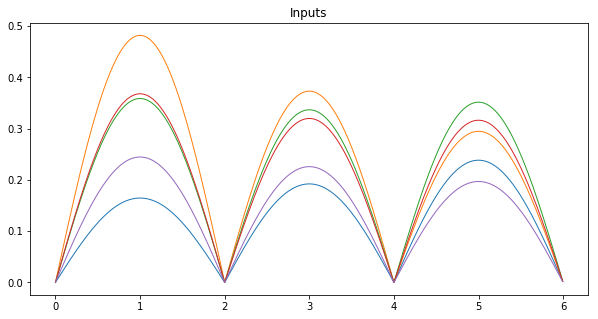

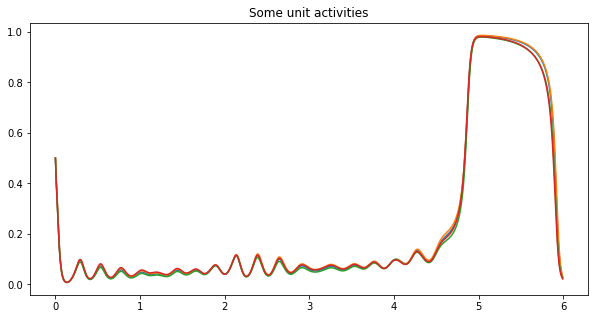

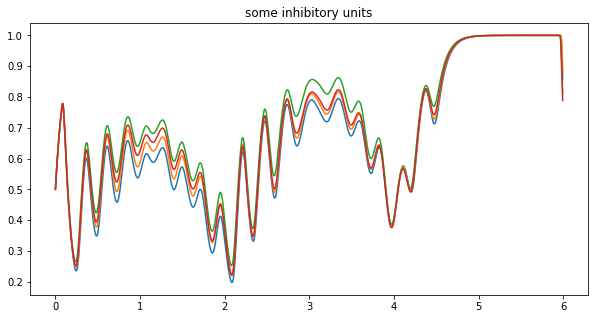

In [7]:
""" Some plots to get a general idea. """
%matplotlib inline
ei.basic_plot()

In [8]:
""" Visualize the activity after the simulation. """
act_ani = ei.activ_anim(0.05, slider=False)
#act_ani.save('act_ani.mp4') # save animation as an mp4 file

In [5]:
""" View the connections. """
ei.print_conn_numbers()
conn_ani = ei.conn_anim(ei.inh, ei.units, slider=True, weights=True)

Average number of incoming EE connections: 26.400000
Average number of incoming EI connections: 100.000000
Average number of incoming IE connections: 13.000000
Average number of incoming II connections: 11.800000
Average number of incoming inp-E connections: 5.000000
Average number of incoming inp-I connections: 5.000000


interactive(children=(IntSlider(value=200, description='frame', max=400, min=1), Output()), _dom_classes=('widget-interact',))

In [ ]:
""" Running again from the last state. """
# Executing run again overwrites the results from the last simulation.
n_presentations = 1
t_presentation = 2.
ei.run(n_presentations, t_presentation)